<a href="https://colab.research.google.com/github/fangyiyu/Fangyi_Yu_Modified_MNIST/blob/master/tensorflow_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
!wget -O comp551w18-modified-mnist.zip https://www.dropbox.com/sh/dhu4cu8l8e32cvl/AACSbGE9X6P7an61STwwr8R0a?dl=0

--2020-09-29 19:16:00--  https://www.dropbox.com/sh/dhu4cu8l8e32cvl/AACSbGE9X6P7an61STwwr8R0a?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/dhu4cu8l8e32cvl/AACSbGE9X6P7an61STwwr8R0a [following]
--2020-09-29 19:16:00--  https://www.dropbox.com/sh/raw/dhu4cu8l8e32cvl/AACSbGE9X6P7an61STwwr8R0a
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1f7dce1b25a7bb4ef1862f826c.dl.dropboxusercontent.com/zip_download_get/AjsivOLFUYD50h0s4D_lH0a5YGJfa7GV9vzqmAA0VooA8B0IrG3raNLgMdIgOmcW-Utu6oBsPjp8Q62ITMy3eLPCqaQ_i7MB5tqYtcrawF0mWg [following]
--2020-09-29 19:16:01--  https://uc1f7dce1b25a7bb4ef1862f826c.dl.dropboxusercontent.com/zip_download_get/AjsivOLFUYD50h0s4D_lH0a5YGJfa7GV9vzqmAA0VooA8B0IrG3raNLgMdIgOmcW-Utu6oBsPjp8Q62IT

In [ ]:
!unzip comp551w18-modified-mnist.zip

Archive:  comp551w18-modified-mnist.zip
  inflating: test_x.csv              
  inflating: train_y.csv             
  inflating: train_x.csv             


In [ ]:
!ls

comp551w18-modified-mnist.zip  sample_data  train_x.csv
instruction.txt		       test_x.csv   train_y.csv


In [ ]:
import numpy as np
x = np.loadtxt("train_x.csv", delimiter=",")# load from text
y = np.loadtxt("train_y.csv", delimiter=",")
x = x.reshape(-1, 64, 64) # reshape
y = y.reshape(-1, 1)

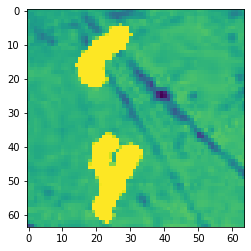

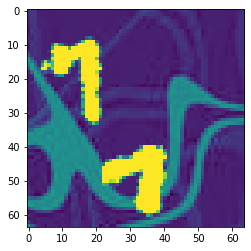

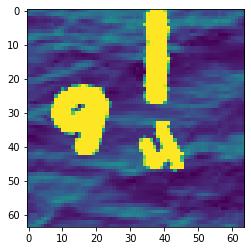

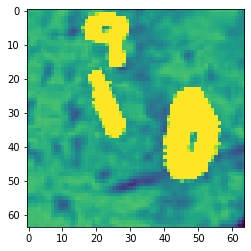

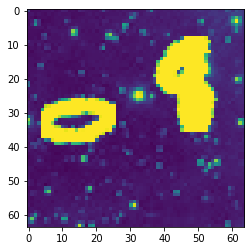

In [70]:
import matplotlib.pyplot as plt
for i in range(5):
    plt.figure()
    plt.imshow(x[i])

This project is using Modified MNIST handwritten digits. The dataset contains 50000 examples for training and 10000 for testing. The digits will be size-normalized and centered in a fixed-size image(64*64 pixels) with values from 0 to 255. 

# 1. Data Preprocessing

In [ ]:
# Split dataset into test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

In [ ]:
# MNIST dataset parameters.
num_classes = 10 # 0 to 9 digits
num_features = 4096 # 64*64

# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 4096 features (64*264).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [ ]:
y_test = y_test.reshape(len(y_test), )
y_test = y_test.astype(int)

In [ ]:
y_train = y_train.reshape(len(y_train), )
y_train = y_train.astype(int)

# 2. Logistic Regression

To feed in the LR model, each image will be converted to float 32, normalized to [0,1] and flattened to a 1-D array of 4096 features(64*64).

In [ ]:
from __future__ import absolute_import, division, print_function
# Training parameters.
learning_rate = 0.01
training_steps = 500
batch_size = 128
display_step = 50

In [ ]:
# Use tf.data API to shuffle and batch data.
import tensorflow as tf
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [ ]:
# Weight of shape [4096, 10], the 64*64 image features, and total number of classes.
W = tf.Variable(tf.ones([num_features, num_classes]), name="weight")
# Bias of shape [10], the total number of classes.
b = tf.Variable(tf.zeros([num_classes]), name="bias")

In [ ]:
# Logistic regression (Wx + b).
def logistic_regression(x):
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(tf.matmul(x, W) + b)

# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred),1))

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

In [ ]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = logistic_regression(x)
        loss = cross_entropy(pred, y)

    # Compute gradients.
    gradients = g.gradient(loss, [W, b])
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, [W, b]))

In [ ]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = logistic_regression(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 50, loss: 2.253382, accuracy: 0.140625
step: 100, loss: 2.190980, accuracy: 0.218750
step: 150, loss: 2.227920, accuracy: 0.140625
step: 200, loss: 2.243543, accuracy: 0.187500
step: 250, loss: 2.241438, accuracy: 0.156250
step: 300, loss: 2.219829, accuracy: 0.210938
step: 350, loss: 2.235283, accuracy: 0.171875
step: 400, loss: 2.206858, accuracy: 0.187500
step: 450, loss: 2.271473, accuracy: 0.148438
step: 500, loss: 2.213220, accuracy: 0.195312


In [ ]:
# Test model on validation set.
pred = logistic_regression(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.119600


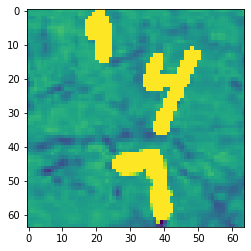

Model prediction: 0


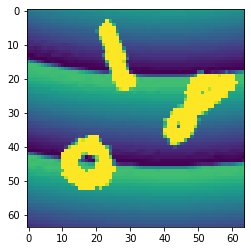

Model prediction: 6


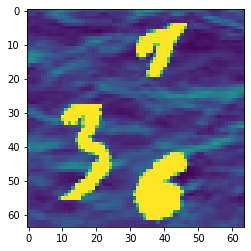

Model prediction: 6


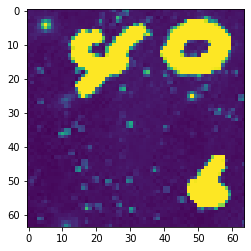

Model prediction: 3


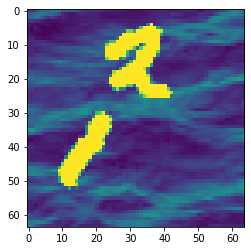

Model prediction: 0


In [ ]:
# Predict 5 images from validation set.
n_images = 5
test_images = x_test[:n_images]
predictions = logistic_regression(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [64, 64]))
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))

# 3. Convolutional Neural Networks

Unlike Logistic Regression and Recurrent Neural Networks, an advantage of CNN is that the input data doesn't need to be flattened, thus we will reshape the data to its origial shape to fit the model.

In [153]:
# Modified MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).

# Training parameters.
learning_rate = 0.01
training_steps = 500
batch_size = 128
display_step = 50
dropout = 0.7

# Network parameters.
num_input = 4096
conv1_filters = 16 # number of filters for 1st conv layer.
conv2_filters = 32 # number of filters for 2nd conv layer.
conv3_filters = 128 # number of filters for 3nd conv layer.
fc1_units = 1024 # number of neurons for 1st fully-connected layer.

In [ ]:
(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

((40000, 4096), (10000, 4096), (40000,), (10000,))

In [ ]:
# # Use tf.data API to shuffle and batch data.
# train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [ ]:
# Create some wrappers for simplicity.
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation.
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # MaxPool2D wrapper.
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [ ]:
# Store layers weight & bias

# A random value generator to initialize weights.
random_normal = tf.initializers.RandomNormal()

weights = {
    # Conv Layer 1: 5x5 conv, 1 input, 16 filters 
    'wc1': tf.Variable(random_normal([5, 5, 1, conv1_filters])),
    # Conv Layer 2: 3x3 conv, 16 inputs, 32 filters.
    'wc2': tf.Variable(random_normal([3, 3, conv1_filters, conv2_filters])),
    # Conv Layer 3: 3x3 conv, 32 inputs, 128 filters
    'wc3': tf.Variable(random_normal([3, 3, conv2_filters, conv3_filters])),
    # FC Layer 1: 8*8*128 inputs, 1024 units.
    'wd1': tf.Variable(random_normal([8*8*128, fc1_units])),
    # FC Out Layer: 1024 inputs, 10 units (total number of classes)
    'out': tf.Variable(random_normal([fc1_units, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.zeros([conv1_filters])),
    'bc2': tf.Variable(tf.zeros([conv2_filters])),
    'bc3': tf.Variable(tf.zeros([conv3_filters])),
    'bd1': tf.Variable(tf.zeros([fc1_units])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

In [ ]:
# Create model
def conv_net(x):
    
    # Input shape: [-1, 64, 64, 1]. A batch of 64x64x1 images.
    x = tf.reshape(x, [-1, 64, 64, 1])

    # Convolution Layer. Output shape: [-1, 64, 64, 16].
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    
    # Max Pooling (down-sampling). Output shape: [-1, 32, 32, 16].
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer. Output shape: [-1, 32, 32, 32].
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    
    # Max Pooling (down-sampling). Output shape: [-1, 16, 16, 32].
    conv2 = maxpool2d(conv2, k=2)

    # Convolution Layer. Output shape: [-1, 16, 16, 128].
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    
    # Max Pooling (down-sampling). Output shape: [-1, 8, 8, 128].
    conv3 = maxpool2d(conv3, k=2)

    # Reshape conv3 output to fit fully connected layer input, Output shape: [-1, 8*8*128].
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer, Output shape: [-1, 1024].
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    # Apply ReLU to fc1 output for non-linearity.
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Fully connected layer, Output shape: [-1, 10].
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(out)

In [ ]:
# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# ADAM optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

In [ ]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = conv_net(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [ ]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = conv_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 50, loss: 292.271576, accuracy: 0.171875
step: 100, loss: 294.924744, accuracy: 0.132812
step: 150, loss: 293.219299, accuracy: 0.156250
step: 200, loss: 295.003632, accuracy: 0.109375
step: 250, loss: 294.546509, accuracy: 0.117188
step: 300, loss: 294.359894, accuracy: 0.109375
step: 350, loss: 294.945099, accuracy: 0.101562
step: 400, loss: 294.848694, accuracy: 0.109375
step: 450, loss: 295.531647, accuracy: 0.062500
step: 500, loss: 293.324005, accuracy: 0.109375


In [ ]:
# Test model on validation set.
pred = conv_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.111600


# 4. Gated CNN
The convolutional layer in GCNN used a gating mechanism to allow the network to control what information should be propagated the hierarchy of layers.

In [154]:
# Create some wrappers for simplicity.
def gconv2d(x, W, b, V, c, num, strides=1):
    # Conv2D wrapper, with bias and gates.
    A = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    B = tf.nn.conv2d(x, V, strides=[1, strides, strides, 1], padding='SAME')
    A = tf.nn.bias_add(A, b)
    A = tf.nn.bias_add(B, c)
    return tf.math.multiply(A, tf.math.sigmoid(B))

In [155]:
# Store layers weight & bias

# A random value generator to initialize weights.
random_normal = tf.initializers.RandomNormal()

weights = {
    # Conv Layer 1: 5x5 conv, 1 input, 16 filters 
    'wc1': tf.Variable(random_normal([5, 5, 1, conv1_filters])),
    'wv1': tf.Variable(random_normal([5, 5, 1, conv1_filters])),
    'c1': tf.Variable(5.),
    # Conv Layer 2: 3x3 conv, 16 inputs, 32 filters.
    'wc2': tf.Variable(random_normal([3, 3, conv1_filters, conv2_filters])),
    'wv2': tf.Variable(random_normal([3, 3, conv1_filters, conv2_filters])),
    'c2': tf.Variable(3.),
    # Conv Layer 3: 3x3 conv, 32 inputs, 128 filters
    'wc3': tf.Variable(random_normal([3, 3, conv2_filters, conv3_filters])),
    'wv3': tf.Variable(random_normal([3, 3, conv2_filters, conv3_filters])),
    'c3': tf.Variable(3.),
    # FC Layer 1: 8*8*128 inputs, 1024 units.
    'wd1': tf.Variable(random_normal([8*8*128, fc1_units])),
    # FC Out Layer: 1024 inputs, 10 units (total number of classes)
    'out': tf.Variable(random_normal([fc1_units, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.zeros([conv1_filters])),
    'bv1': tf.Variable(tf.zeros([conv1_filters])),
    'bc2': tf.Variable(tf.zeros([conv2_filters])),
    'bv2': tf.Variable(tf.zeros([conv2_filters])),
    'bc3': tf.Variable(tf.zeros([conv3_filters])),
    'bv3': tf.Variable(tf.zeros([conv3_filters])),
    'bd1': tf.Variable(tf.zeros([fc1_units])),
    'out': tf.Variable(tf.zeros([num_classes]))
}


In [156]:
# Create model
def gconv_net(x):
    
    # Input shape: [-1, 64, 64, 1]. A batch of 64x64x1 images.
    x = tf.reshape(x, [-1, 64, 64, 1])

    # Convolution Layer. Output shape: [-1, 64, 64, 16].
    conv1 = gconv2d(x, weights['wc1'], biases['bc1'], weights['wv1'], biases['bv1'], weights['c1'])
    # Max Pooling (down-sampling). Output shape: [-1, 32, 32, 16].
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer. Output shape: [-1, 32, 32, 32].
    conv2 = gconv2d(conv1, weights['wc2'], biases['bc2'], weights['wv2'], biases['bv2'], weights['c2'])
    # Max Pooling (down-sampling). Output shape: [-1, 16, 16, 32].
    conv2 = maxpool2d(conv2, k=2)

    # Convolution Layer. Output shape: [-1, 16, 16, 128].
    conv3 = gconv2d(conv2, weights['wc3'], biases['bc3'], weights['wv3'], biases['bv3'], weights['c3'])
    # Max Pooling (down-sampling). Output shape: [-1, 8, 8, 128].
    conv3 = maxpool2d(conv3, k=2)

    # Reshape conv3 output to fit fully connected layer input, Output shape: [-1, 8*8*128].
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer, Output shape: [-1, 1024].
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    # Apply ReLU to fc1 output for non-linearity.
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Fully connected layer, Output shape: [-1, 10].
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(out)

In [157]:
# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# ADAM optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

In [158]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = gconv_net(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients((grad, var) for (grad, var) in zip(gradients, trainable_variables) if grad is not None)

In [160]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = gconv_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 50, loss: 295.425873, accuracy: 0.070312
step: 100, loss: 294.479523, accuracy: 0.109375
step: 150, loss: 295.384125, accuracy: 0.046875
step: 200, loss: 294.753174, accuracy: 0.109375
step: 250, loss: 294.776031, accuracy: 0.101562
step: 300, loss: 294.379272, accuracy: 0.125000
step: 350, loss: 294.968475, accuracy: 0.109375
step: 400, loss: 294.384460, accuracy: 0.125000
step: 450, loss: 295.506714, accuracy: 0.109375
step: 500, loss: 294.334106, accuracy: 0.140625


# 5. Recurrent Neural Networks_LSTM

To classify images using a recurrent neural network, we consider every image row as a sequence of pixels. Because Modified MNIST image shape is 64*64px, we will then handle 64 sequences of 64 timesteps for every sample.

In [127]:
from keras.utils import np_utils
y_train_r = np_utils.to_categorical(y_train, num_classes)
y_test_r = np_utils.to_categorical(y_test, num_classes)

In [129]:
(x_train.shape,x_test.shape,y_train_r.shape,y_test_r.shape)

((40000, 4096), (10000, 4096), (40000, 10), (10000, 10))

In [133]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, LSTM, BatchNormalization
# Hyper parameters
batch_size = 128
nb_epoch = 30
# Parameters for MNIST dataset
img_rows, img_cols = 64, 64
nb_classes = 10
# Parameters for LSTM network
nb_lstm_outputs = 30
nb_time_steps = img_rows
dim_input_vector = img_cols
input_shape = (64, 64)

x_train=x_train.reshape(x_train.shape[0],64,64)
x_test=x_test.reshape(x_test.shape[0],64,64)

model_LSTM = Sequential()
model_LSTM.add(LSTM(nb_lstm_outputs, input_shape=input_shape))
model_LSTM.add(Dense(10, activation='softmax'))
model_LSTM.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                11400     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
Total params: 11,710
Trainable params: 11,710
Non-trainable params: 0
_________________________________________________________________


In [134]:
# Train the model
history = model_LSTM.fit(x_train, 
                    y_train_r, 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    shuffle=True,
                    validation_data=(x_test, y_test_r),
                    verbose=1)

Epoch 1/30
313/313 [==============================] - 3s 10ms/step - loss: 2.3048 - accuracy: 0.1078 - val_loss: 2.3029 - val_accuracy: 0.0978
Epoch 2/30
313/313 [==============================] - 3s 9ms/step - loss: 2.2961 - accuracy: 0.1186 - val_loss: 2.2901 - val_accuracy: 0.1289
Epoch 3/30
313/313 [==============================] - 3s 9ms/step - loss: 2.2785 - accuracy: 0.1373 - val_loss: 2.2848 - val_accuracy: 0.1291
Epoch 4/30
313/313 [==============================] - 3s 9ms/step - loss: 2.2481 - accuracy: 0.1607 - val_loss: 2.2411 - val_accuracy: 0.1581
Epoch 5/30
313/313 [==============================] - 3s 8ms/step - loss: 2.2237 - accuracy: 0.1711 - val_loss: 2.2249 - val_accuracy: 0.1663
Epoch 6/30
313/313 [==============================] - 3s 8ms/step - loss: 2.2118 - accuracy: 0.1754 - val_loss: 2.2162 - val_accuracy: 0.1700
Epoch 7/30
313/313 [==============================] - 3s 8ms/step - loss: 2.2003 - accuracy: 0.1826 - val_loss: 2.2173 - val_accuracy: 0.1685
Epoch

# 6. CNN_VGG
Apart from the vanila CNN model, I used a pre-trained model VGG here to get a better performance.

In [135]:
x_train, x_test = x_train.reshape([-1,64,64,1]), x_test.reshape([-1,64,64,1])

In [137]:
# Data augmentation
from keras.preprocessing.image import ImageDataGenerator
input_shape = (64,64,1)
datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1,
    shear_range=0.2,
    height_shift_range=0.1,
    zoom_range=0.2
    )

datagen.fit(x_train)

In [138]:
# Build model
def VGG_modified(input_shape, opt = tf.keras.optimizers.Adam(amsgrad=True)):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=input_shape,
                            data_format="channels_last"))
    model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    #sgd=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [140]:
model = VGG_modified((64,64,1))
history = model.fit_generator(datagen.flow(x_train, y_train_r, batch_size=64),
                              validation_data=(x_test, y_test_r),
                              epochs = 10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
625/625 [==============================] - 32s 51ms/step - loss: 2.2400 - accuracy: 0.1716 - val_loss: 2.4165 - val_accuracy: 0.0668
Epoch 2/10
625/625 [==============================] - 31s 50ms/step - loss: 1.9910 - accuracy: 0.2522 - val_loss: 2.6888 - val_accuracy: 0.1186
Epoch 3/10
625/625 [==============================] - 31s 49ms/step - loss: 1.4424 - accuracy: 0.4958 - val_loss: 1.7247 - val_accuracy: 0.5278
Epoch 4/10
625/625 [==============================] - 31s 49ms/step - loss: 0.9167 - accuracy: 0.7198 - val_loss: 0.4368 - val_accuracy: 0.8831
Epoch 5/10
625/625 [==============================] - 31s 49ms/step - loss: 0.6521 - accuracy: 0.8234 - val_loss: 0.3477 - val_accuracy: 0.9114
Epoch 6/10
625/625 [==============================] - 31s 49ms/step - loss: 0.4997 - accuracy: 0.8644 - val_loss: 0.3395 - val_accuracy: 0.9071
Epoch 7/10
625/625 [==============================] - 31s 49